In [1]:
import pandas as pd 
import numpy as np
import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision 

In [2]:
torch.__version__

'2.9.1+cu128'

In [3]:
print(torch.version.cuda)
print(torch.cuda.is_available())

12.8
True


In [4]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3050 6GB Laptop GPU'

In [5]:
class celebDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.root_dir = img_dir
        self.transform = transform
        self.image_paths = [
        os.path.join(img_dir, img)
        for img in os.listdir(img_dir)
        if img.endswith('.jpg')]
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
       
        if self.transform:
            image = self.transform(image)
        
        return image


In [8]:
transform = transforms.Compose([
    transforms.Resize(64),  # Resize images to 64x64
    transforms.CenterCrop(64),  # Crop center to 64x64
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load CelebA dataset from the specified directory
dataset_path = 'img_align_celeba'
dataset = celebDataset(img_dir=dataset_path, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Check how many images are loaded
print(f"Total number of images loaded: {len(dataset)}")

Total number of images loaded: 39437


In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, img_channels * 64 * 64),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 64, 64)  # Reshape to image format
        return img

In [11]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_channels * 64 * 64, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

In [12]:
# Loss function and optimizers
adversarial_loss = nn.BCELoss()
generator = Generator(z_dim=100)
discriminator = Discriminator()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

In [14]:
#Train the GAN
def train(generator, discriminator, dataloader, epochs=5):
    for epoch in range(epochs):
        for i, imgs in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batch_size = real_imgs.size(0)
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, 100).to(device)).detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, 100).to(device))), valid)
            g_loss.backward()
            optimizer_G.step()

            if i % 50 == 0:
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # Optionally, save generated images at each epoch
        # save_generated_images(generator, epoch, device)

In [15]:
def save_generated_images(generator, epoch, device, num_images=16):
    z = torch.randn(num_images, 100).to(device)
    generated_imgs = generator(z).detach().cpu()
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f"Epoch {epoch}")
    plt.axis('off')
    plt.show()

# Start training
train(generator, discriminator, dataloader, epochs=10)

[Epoch 0/10] [Batch 0/309] [D loss: 0.6867750883102417] [G loss: 0.7124224901199341]
[Epoch 0/10] [Batch 50/309] [D loss: 0.3402632474899292] [G loss: 1.031893253326416]
[Epoch 0/10] [Batch 100/309] [D loss: 1.2127149105072021] [G loss: 0.36150866746902466]
[Epoch 0/10] [Batch 150/309] [D loss: 0.6776156425476074] [G loss: 0.5159107446670532]
[Epoch 0/10] [Batch 200/309] [D loss: 0.23917093873023987] [G loss: 1.2002856731414795]
[Epoch 0/10] [Batch 250/309] [D loss: 0.2071928083896637] [G loss: 2.1577205657958984]
[Epoch 0/10] [Batch 300/309] [D loss: 0.38427332043647766] [G loss: 1.1371965408325195]
[Epoch 1/10] [Batch 0/309] [D loss: 0.33323758840560913] [G loss: 0.7271960377693176]
[Epoch 1/10] [Batch 50/309] [D loss: 0.06852702051401138] [G loss: 2.4427337646484375]
[Epoch 1/10] [Batch 100/309] [D loss: 0.06480419635772705] [G loss: 2.569460391998291]
[Epoch 1/10] [Batch 150/309] [D loss: 0.14917927980422974] [G loss: 2.223172664642334]
[Epoch 1/10] [Batch 200/309] [D loss: 0.15599

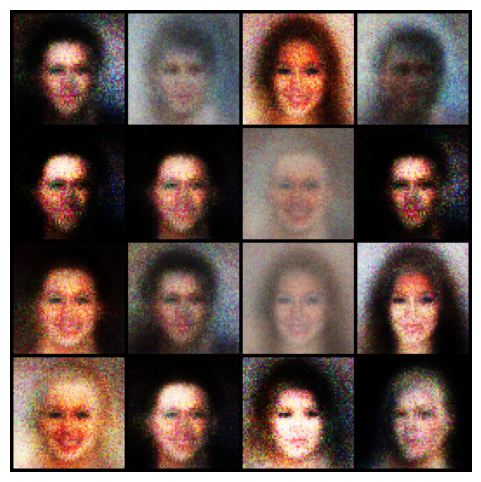

In [20]:
noise = torch.randn(16, 100, device=device)

with torch.no_grad():
    fake_images = generator(noise).cpu()

grid = torchvision.utils.make_grid(fake_images, nrow=4, normalize=True)

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()
